In [1]:
from matplotlib.pyplot import subplots, tight_layout, figure

from numpy import loadtxt, reshape, mean, corrcoef, cumsum

import nibabel as nib


# Overview

- Concept of decomposition

- Preprocessing

- Principal Components

- Explained variance and principal components


# What is dimensionality reduction?

- High dimensional datasets are characterised by large number of measured features
- Typical examples are neuroimaging (eg. fMRI and EEG), transcriptomics studies, mutation/risk factor studies


- This can be a problem for data exploration, visualisation, storage and machine learning applications


- Dimensionality reduction methods generally do two things for optimal "data compression":
  - reduce the number of columns (features).   Each feature is a "combination" of the original measured features
  - retain maximal variance/separability // minimize information loss

<img src="goal.png">

# Load and Visualise fMRI Data 

We will use some fMRI BOLD imaging data when human subjects were viewing different visual stimuli. For more on BOLD imaging, see [here](https://www.sciencedirect.com/science/article/pii/B9780123864567076103)

The original dataset is from: http://www.pymvpa.org/datadb/haxby2001.html

In [2]:
fmri_raw = nib.load("bold.nii")

In [3]:
# Convert to numpy array

img1 = fmri_raw.get_fdata()

img1.shape


(40, 64, 64, 1452)

In [4]:
# This is a 4D dataset - a signal timeseries of a 3D volume
# Different from a structural MRI

[nX, nY, nSlices, nTimepoints] = img1.shape

print( 'nX = ', nX, ', nY = ', nY, ', Slices = ', nSlices, ', nFrames = ', nTimepoints)

nX =  40 , nY =  64 , Slices =  64 , nFrames =  1452


In [5]:
my_slice = 40

data_series = img1[:,:,my_slice,:]

data_series.shape  


(40, 64, 1452)

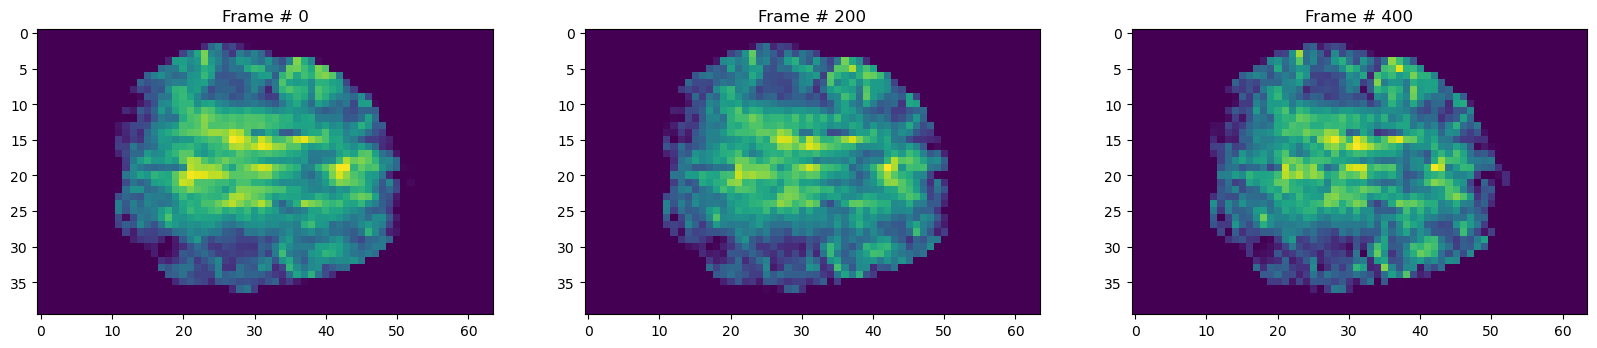

In [6]:
# Plot different timeframes of the same slice

frames = 3

fig, ax = subplots(ncols=frames, figsize=(20, 4))

for ctr in range(frames):

    frame = ctr*200
    
    im = ax[ctr].imshow(data_series[:,:, frame], vmin=1600)

    ax[ctr].set_title('Frame # '+ str(frame) )


## Preprocessing

- Mask image
- Combine all slices and pixels as features
- Normalise data

We skip these steps to directly load the preprocessed data:

# Load Pre-processed Data

In [7]:
data_preprocessed = loadtxt('data_preprocessed.csv',delimiter=",")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data_preprocessed)

data.shape


(1452, 1244)

Time points are in the rows, pixels in the columns.

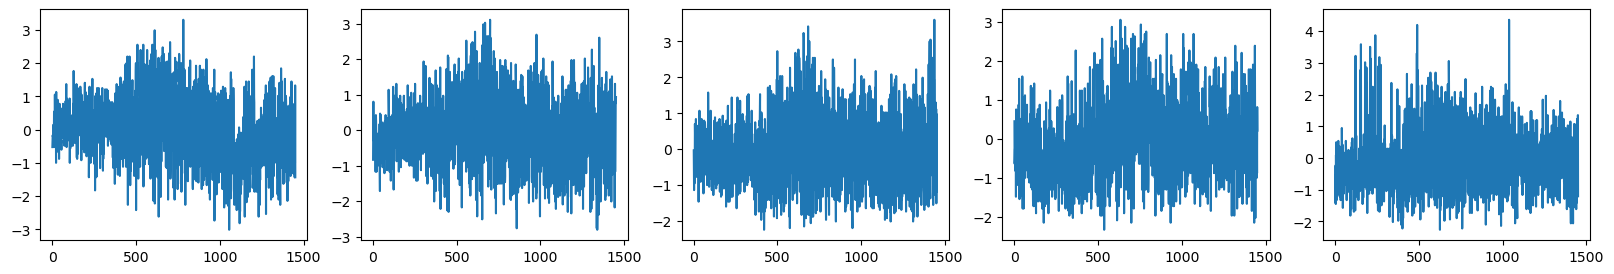

In [8]:
# Time series of individual pixels

pixels = 5

fig, ax = subplots(ncols=pixels, figsize=(20, 3))


for pixel in range(pixels):
    
    ax[pixel].plot(data[:,pixel])


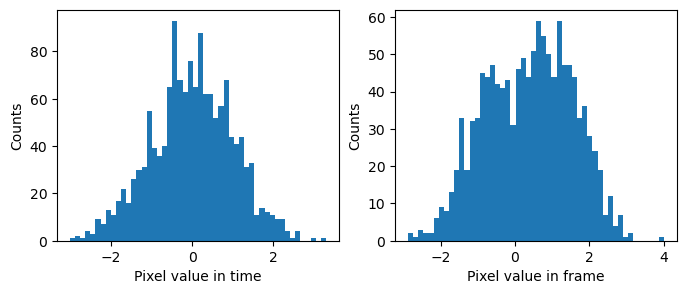

In [13]:
# Histogram of a time series (left) and a single image (right).

fig, ax = subplots(ncols=2, figsize=(8, 3))

ax[0].hist(data[:, 0].flatten(), bins=50);
ax[0].set_xlabel('Pixel value in time');
ax[0].set_ylabel('Counts');

ax[1].hist(data[0, :].flatten(), bins=50);
ax[1].set_xlabel('Pixel value in frame');
ax[1].set_ylabel('Counts');

Typically, there are many other pre-processing steps, including correcting for brain movement, removing outlier frames, transforming data using some kernels ("functional PCA") - but for this tutorial, we will work with this preprocessing.

# PCA

Principal component analysis is a very commonly used dimensionality reduction method - for data exploration and visualisation, as well as for preprocessing data for machine learning applications.

Retaining lots of pixels with correlated variability can be a problem for fitting supervised learning models - esp when number of samples << number of features.

Instead, PCA transforms the data into a _feature space_ which allows an adequate description of the data with a fewer number of features.

## State Space plots

In a state space plot, we use the activity of each pixel as a different axis. Thus each row is a point in this state space. 

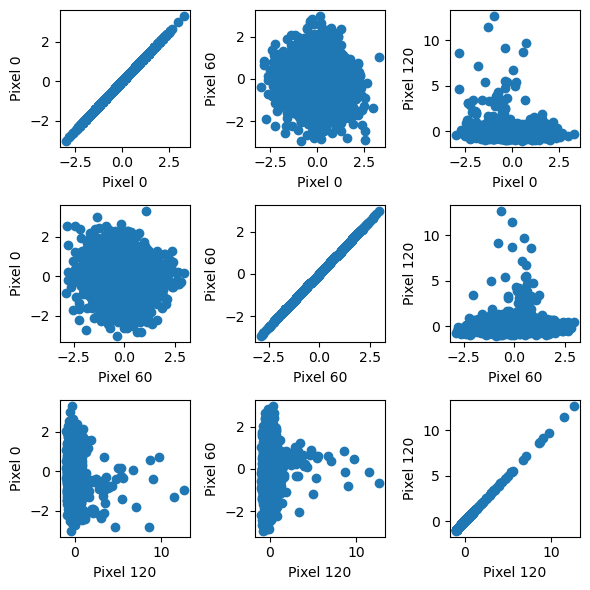

In [14]:
# Plotting for the first 3 pixels:

fig, ax = subplots(nrows=3, ncols=3, figsize=(6, 6))

for pixel1 in range(3): 
    
    for pixel2 in range(3):
        
        pick = 60
        
        ax[pixel1,pixel2].scatter(data[:,pixel1*pick], data[:,pixel2*pick])
        ax[pixel1,pixel2].set_xlabel('Pixel ' + str(pixel1*pick))
        ax[pixel1,pixel2].set_ylabel('Pixel ' + str(pixel2*pick))

fig.tight_layout()

The activity along pixels co-varies to some extent

## Apply PCA

Goal:  Convert from   [Tx N]   to   [Tx K], where K<N

### X-Y Sketch

In [15]:
data.shape

(1452, 1244)

In [16]:
from sklearn.decomposition import PCA


In [17]:
nComp = 200

pca = PCA(n_components=nComp)

pca.fit(data)


PCA(n_components=200)

## Variance captured

In [18]:
# variance by each component (normalised)
exp_var = pca.explained_variance_ratio_

# total variance explained
cumu_exp_var = cumsum(exp_var) / sum(exp_var)


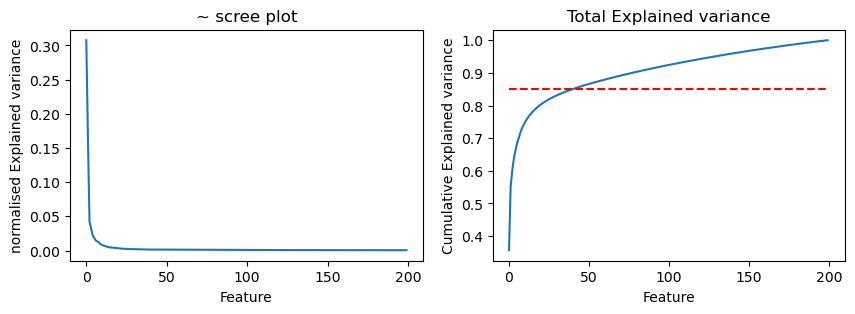

In [19]:
fig, ax = subplots(ncols=2, figsize=(10,3))

ax[0].plot(exp_var)
ax[0].set_xlabel('Feature'); 
ax[0].set_ylabel('normalised Explained variance');
ax[0].set_title('~ scree plot');

ax[1].plot(cumu_exp_var)
ax[1].set_xlabel('Feature'); 
ax[1].set_ylabel('Cumulative Explained variance');
ax[1].set_title('Total Explained variance');

threshold = 0.85

ax[1].hlines(threshold, 0, len(cumu_exp_var), 'r', linestyles='dashed');
# ax[1].margins(x=0)


There are two common heuristics for selecting number of components:
- Find the 'elbow' in the [scree plot](https://methods.sagepub.com/reference/the-sage-encyclopedia-of-educational-research-measurement-and-evaluation/i18507.xml#:~:text=A%20scree%20plot%20is%20a,analysis%20or%20a%20factor%20analysis.) (where successive components have dramatically lower contributions)
- Keep a minimum number of features such that cumulative explained variance is 80-90% (or any pre-determined threshold)

## Selecting number of features

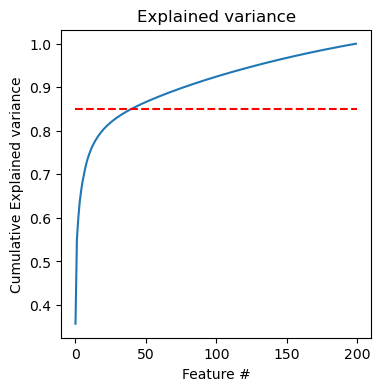

In [20]:
threshold = 0.85

fig,ax = subplots(figsize=(4,4))

ax.plot(cumu_exp_var)
ax.plot([0,nComp],[threshold,threshold],'r--')

ax.set_xlabel('Feature #'); 
ax.set_ylabel('Cumulative Explained variance');
ax.set_title('Explained variance');


## Fit and transform

Let's fit and transform the data into this smaller feature space, determined by _minPC_

In [21]:
pca2 = PCA(n_components=50)

data_reduced = pca2.fit_transform(data)


In [22]:
data.shape, data_reduced.shape

((1452, 1244), (1452, 50))

## Visualise data in PC space

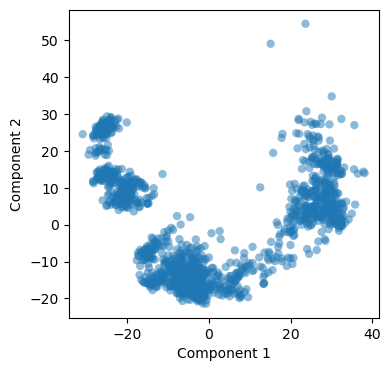

In [23]:
## Looking at new projected data along the first two features

fig,ax = subplots(figsize=(4,4))

ax.scatter(data_reduced[:, 0], data_reduced[:, 1], edgecolor='none', alpha=0.5)
ax.set_xlabel('Component 1');
ax.set_ylabel('Component 2');


These axes are the principal components

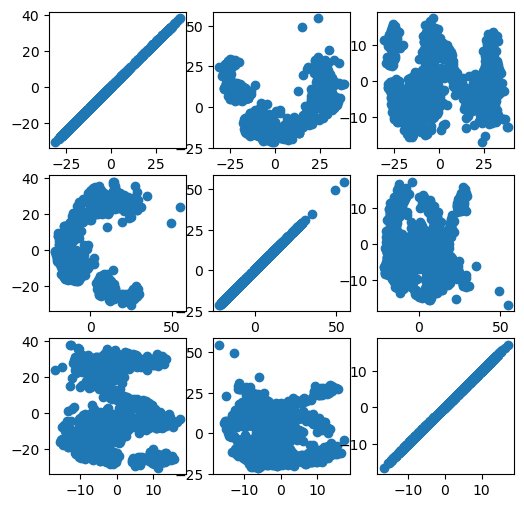

In [24]:
## Plot a few more

comps = 3

fig, ax = subplots(nrows=comps, ncols=comps, figsize=(6, 6))

for comp1 in range(comps):
    
    for comp2 in range(comps):
        
        ax[comp1, comp2].scatter(data_reduced[:,comp1], data_reduced[:,comp2])
        